In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#### modules

In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from scipy.stats import entropy
from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import sys 
_HOME_ = "/mnt/d"
import plotting 
import modify_dataset
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
from scipy import stats 
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors

/home/alberto/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def Pielou_evenness(data): 
    if data.size == 1: 
        return 0
    H = entropy(data, base = 10)
    H_max = np.log10(len(data))
    return H / H_max

### Basics variables and parameters

In [8]:
phyto_abundances = pd.read_csv(_HOME_ + "/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [9]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [10]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [11]:
taxonomic_tree = pd.read_excel(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [12]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [13]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [14]:
transects_info = pd.read_csv("/mnt/d/PHD/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [14]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Italy_map_lat_long.txt", "r") as in_file:
    all_lines = in_file.readlines()
    x_pen, y_pen, x_sic, y_sic, x_sard, y_sard = list(filter(lambda x : not (x.startswith('#') or x=="\n"), all_lines))
x_pen = list(map(float, x_pen[:-1].split(' ')))
y_pen = list(map(float, y_pen[:-1].split(' ')))
x_sic = list(map(float, x_sic[:-1].split(' ')))
y_sic = list(map(float, y_sic[:-1].split(' ')))
x_sard = list(map(float, x_sard[:-1].split(' ')))
y_sard = list(map(float, y_sard[:-1].split(' ')))

### Are cuts in the freq or abund possible? 
Filtering protocol

Text(0.5, 0, 'Number of samples')

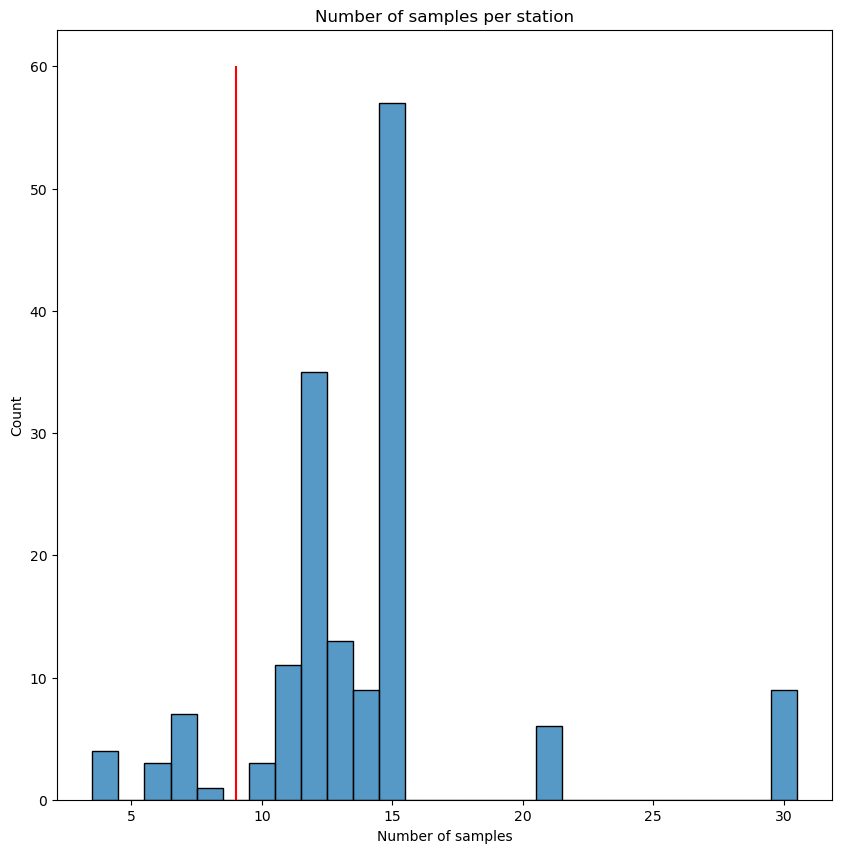

In [13]:

### undersampled locations
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.histplot(phyto_abund_simplified[["id", "Date"]].drop_duplicates().groupby("id").count(), x = "Date", binwidth = 1, binrange = (3.5, 30.5), ax = ax)
ax.vlines(9, 0, 60, color = "red")
ax.set_title("Number of samples per station")
ax.set_xlabel("Number of samples")

In [15]:
# discarding stations having less than 9 samples
minimum_samples = 9
indices_enough_samples = phyto_abund_simplified[["id", "Date"]].drop_duplicates().groupby("id").count().query("Date > @minimum_samples").index

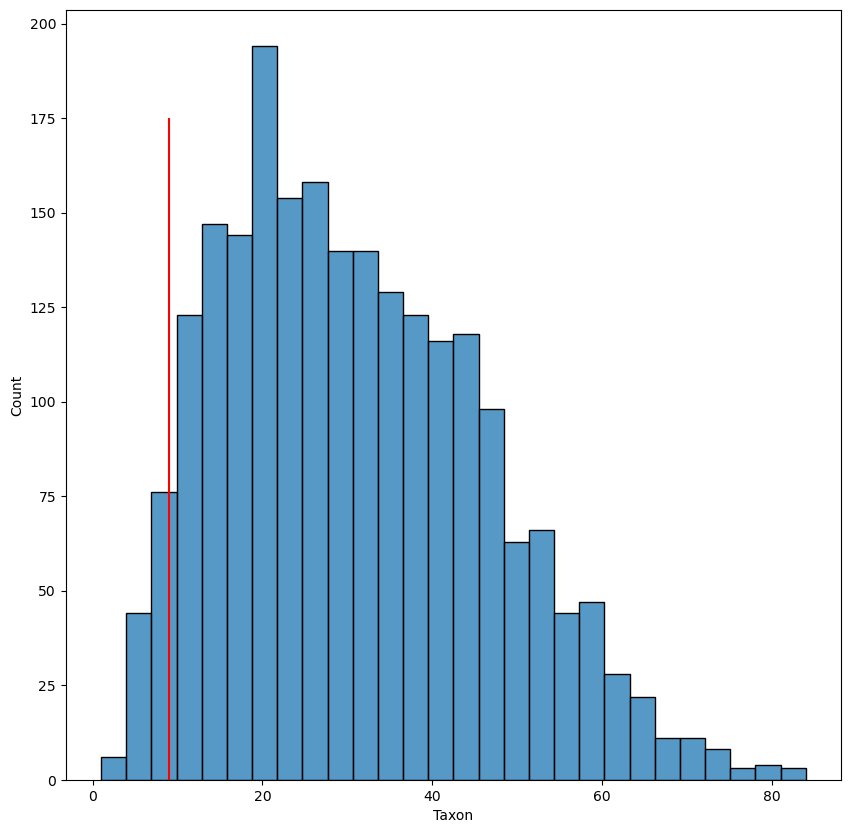

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.histplot(phyto_abund_simplified.groupby(["Region", "id", "Date"]).count(), x = "Taxon", binwidth = 3, ax = ax)
ax.vlines(9, 0, 175, color = "red")

In [16]:
# removing samples having less than n taxa
minimunm_taxa = 5
relevant_samples = phyto_abund_simplified.loc[phyto_abund_simplified["id"].isin(indices_enough_samples), ["id", "Date", "Taxon"]].groupby(["id", "Date"]).count().query("Taxon > @minimunm_taxa").index

# Sampling campaign

In [ ]:
abundances_by_stations = phyto_abund_simplified[["id", "Date", "Num_cell_l"]].groupby(["id", "Date"]).sum().groupby(level = "id").mean()
abundances_by_stations["Num_cell_l"] = np.log10(abundances_by_stations["Num_cell_l"])
abund = abundances_by_stations["Num_cell_l"].to_numpy()
fig, ax = plt.subplots(1,1, figsize=(15,14.9))
plotting.plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.7)
ax.scatter(*phyto_points.loc[abundances_by_stations.index, ["Longitude", "Latitude"]].to_numpy().T, label = "Stations", edgecolor = "k", s = 50)
ax.legend(fontsize = 20)
ax.tick_params(labelsize=15)
ax.set_xlabel("Longitude", fontsize = 20)
ax.set_ylabel("Latitude", fontsize = 20)
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Stations.png", bbox_inches='tight')

In [159]:
data = phyto_abund_simplified[["Region", "Date", "id"]].groupby(by = ["Region", pd.Grouper(key = "Date", freq = "M")]).nunique( 
).divide(phyto_abund_simplified[["Region", "id"]].drop_duplicates().groupby("Region").count()
         ).pivot_table(index = "Region", columns= "Date", values = "id")
data[data.isna()] = 0

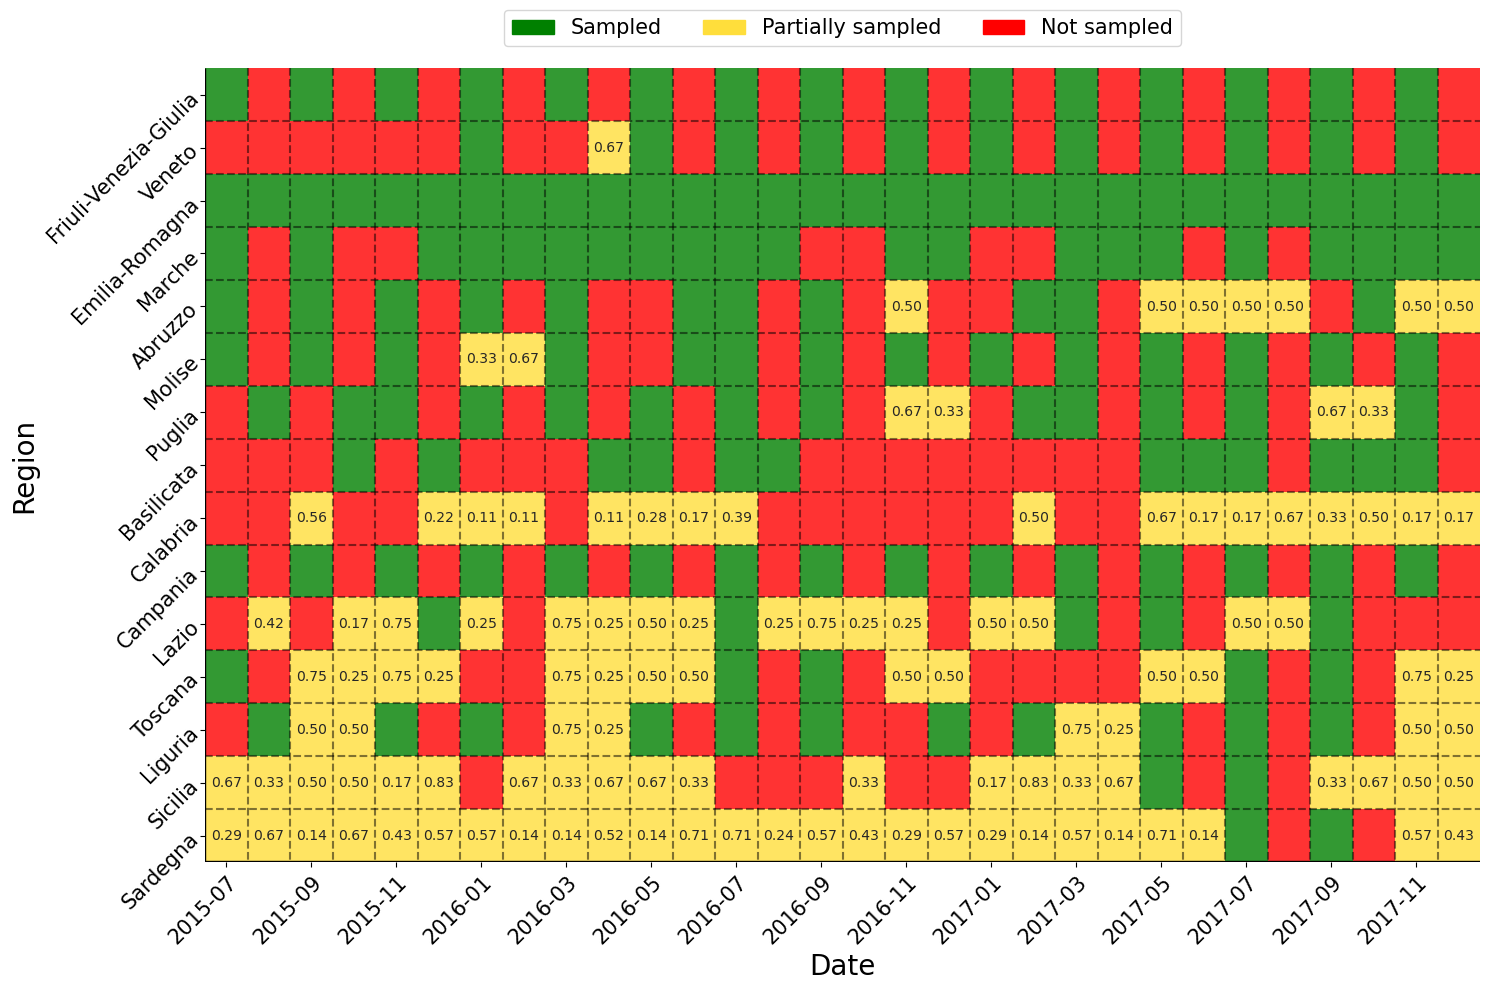

In [33]:
data = phyto_abund_simplified[["Region", "Date", "id"]].groupby(by = ["Region", pd.Grouper(key = "Date", freq = "M")]).nunique( 
).divide(phyto_abund_simplified[["Region", "id"]].drop_duplicates().groupby("Region").count()
         ).pivot_table(index = "Region", columns= "Date", values = "id")
data[data.isna()] = 0
data = data.loc[ordered_regions, :]
annot_label = np.where((data == 0) | (data == 1), "", np.char.mod('%.2f', data))
data[(data > 0) & (data < 1.0)] = 0.5
cmap = colors.ListedColormap(["red", "#FFDE3B", "green"])
fig, ax = plt.subplots(1,1, figsize=(15,10))
heatmap = sns.heatmap(data, ax = ax, 
            cbar = False, 
            cmap = cmap, 
            vmin = 0, 
            vmax = 1,
            alpha = 0.8,
            annot = annot_label, 
            fmt = "",
           )
ax.set_xlabel(ax.get_xlabel(), size = 20)
ax.set_ylabel(ax.get_ylabel(), size = 20)
ax.set_xticks([i + 0.5  for i in range(0, len(data.columns), 2)])
ax.set_xticklabels(data.columns[::2].strftime("%Y-%m"), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15); 
w = ax.get_xticks()
v = ax.get_yticks()
delta_xtick = w[1] - w[0] 
ax.vlines([i + delta_xtick / 4 for i in w], 0, 15, linestyles = "--", colors = "k", alpha = 0.5)
ax.vlines([i - delta_xtick / 4 for i in w[1:]], 0, 15, linestyles = "--", colors = "k", alpha = 0.5)
ax.vlines(0, 0, 15, linestyles = "-", colors = "black", linewidths = 1)
ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 30, linestyles = "--", colors = "k", alpha = 0.5)
ax.hlines(14.98, 0, 30, linestyles = "-", colors = "black", linewidths = 1)
ax.set_yticklabels(ax.get_yticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
sampled = mpatches.Patch(color=cmap(2), label='Sampled')
not_sampled = mpatches.Patch(color=cmap(0), label='Not sampled')
partial = mpatches.Patch(color=cmap(1), label='Partially sampled')
ax.legend(handles=[sampled, partial, not_sampled], bbox_to_anchor = (0, 1.0, 1, 0.101), loc= "center", ncols = 3, fontsize = 15)
plt.tight_layout()
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Regions_date_sampling.png",bbox_inches='tight')

In [ ]:
#df_most_abund_species = df_most_abund_species.query("Num_cell_l >= 3.0") 
figsize_dims = (12,19)
fig, axs = plt.subplots(5,3, figsize=figsize_dims);
axs = axs.flat

for ax, (name, df) in zip(axs, phyto_abundances[["Region", "id", "Sample_depth"]].groupby(by = "Region")): 
    sns.histplot(data = df, x = "Sample_depth", ax = ax)
    ax.set_xlabel("Depth [m]");
    ax.set_ylabel("number of samples");
    ax.set_title(name);
plt.suptitle("Number of samples taken at the corresponding depth for each region")
plt.tight_layout(rect=[0,0,1,0.99])

How many stations reached the bottom? 

In [ ]:
df_deepest_depths = pd.merge(phyto_abundances[["id", "Sample_depth"]].sort_values("Sample_depth",ascending=False).drop_duplicates("id", keep="first"), right= df_lat_long_stations[["id", "Sea_depth"]], left_on="id", right_on="id")

In [ ]:
df_deepest_depths[df_deepest_depths.apply(lambda x: abs(x["Sample_depth"] - x["Sea_depth"]), axis = 1) <= 2.].count()

In [9]:
species_acc_curves = phyto_abund_simplified[["Region", "id", "Date", "Taxon"]].drop_duplicates(["Region", "Taxon"], keep = "first").groupby(["Region", "id", "Date"]).count().reset_index()
species_acc_curves["n_samples"] = 1
species_acc_curves[["new_species", "n_samples"]] = species_acc_curves.groupby(["Region", "id"]).agg({
    "Taxon" : "cumsum", "n_samples" : "cumsum"
})

In [10]:
species_acc_curves = phyto_abund_simplified[["Region", "id", "Date", "Taxon"]].drop_duplicates(["Region", "Taxon"], keep = "first").groupby(["Region", "id", "Date"]).count().reset_index()
species_acc_curves["n_samples"] = 1
species_acc_curves = species_acc_curves.sort_values(["Region", "Taxon"], ascending= [True, False])
species_acc_curves[["new_species", "n_samples"]] = species_acc_curves.groupby("Region").agg({
    "Taxon" : "cumsum", "n_samples" : "cumsum"
})

<Axes: xlabel='n_samples', ylabel='new_species'>

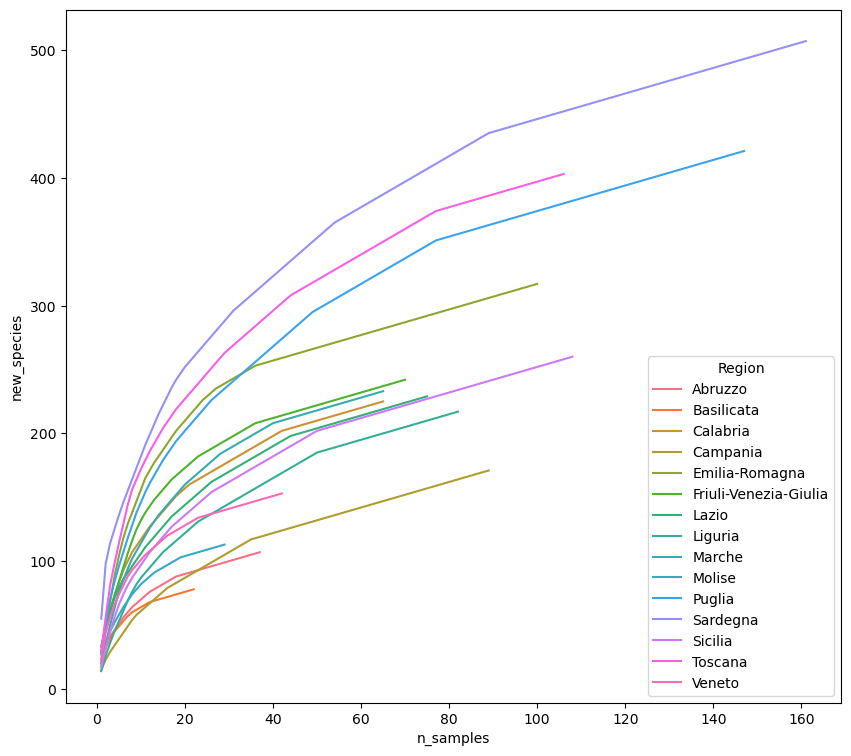

In [164]:
fig, ax = plt.subplots(1,1, figsize = (10,9))
sns.lineplot(species_acc_curves, x = "n_samples", y = "new_species", hue = "Region", ax = ax)


### looking for blooms

### Some Linear models

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.sort_values(by = "Region", key = sorting).groupby("Region", sort=False), fig.axes)): 
    ax.set_yscale("log")
    sns.boxplot(data = group, x = "Season_year", y = "Num_cell_l", ax = ax)
    ax.set_title(group_name)
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.98])

In [74]:
model = smf.mixedlm("np.log10(Num_cell_l) ~ Season_year", df, groups=df["Region"]).fit()
print_model = model.summary()
print(print_model)

                Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  np.log10(Num_cell_l)
No. Observations:  2223     Method:              REML                
No. Groups:        15       Scale:               0.3653              
Min. group size:   36       Log-Likelihood:      -2090.9295          
Max. group size:   270      Converged:           Yes                 
Mean group size:   148.2                                             
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   4.821    0.219 22.059 0.000  4.393  5.250
Season_year[T.Autumn-2016]  0.057    0.064  0.888 0.375 -0.069  0.182
Season_year[T.Autumn-2017]  0.008    0.059  0.135 0.892 -0.108  0.124
Season_year[T.Spring-2016] -0.035    0.058 -0.612 0.541 -0.149  0.078
Season_year[T.Spring-2017]  0.125   

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.sort_values(by = "Region", key = sorting).groupby("Region", sort=False), fig.axes)): 
    sns.boxplot(data = group, x = "Season_year", y = "Num_cell_l", ax = ax)
    ax.set_title(group_name)
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.reset_index().sort_values(by = "Region", key = sorting).query(
    "id in @closest_stations"
).groupby("Region", sort=False), fig.axes)): 
    #ax.set_yscale("log")
    sns.lineplot(data = group, x = "Date", y = "Num_cell_l", hue = "id", marker = ".", markersize = 15, linestyle = "dashed", ax = ax)
    ax.set_title(group_name)
    ax.get_legend().remove()
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [ ]:
closest_stations = phyto_abundances.loc[phyto_abundances["Closest_coast"] <= 6, ["Region", "id", "Closest_coast"]].drop_duplicates().sort_values(["Region", "Closest_coast"]).iloc[:-2,1].to_numpy()
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.reset_index().sort_values(by = "Region", key = sorting).query(
    "id in @closest_stations"
).groupby("Region", sort=False), fig.axes)): 
    ax.set_yscale("log")
    sns.lineplot(data = group, x = "Date", y = "Num_cell_l", hue = "id", marker = ".", markersize = 15, linestyle = "dashed", ax = ax)
    ax.set_title(group_name)
    ax.get_legend().remove()
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [81]:
model = smf.mixedlm("np.log10(Num_cell_l) ~ Date", df, groups=df["Region"]).fit()
print_model = model.summary()
print(print_model)

                       Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      np.log10(Num_cell_l)
No. Observations:        2223         Method:                  REML                
No. Groups:              15           Scale:                   0.3461              
Min. group size:         36           Log-Likelihood:          -2049.5350          
Max. group size:         270          Converged:               Yes                 
Mean group size:         148.2                                                     
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 4.764    0.228 20.936 0.000  4.318  5.210
Date[T.Timestamp('2015-08-31 00:00:00')]  0.111    0.103  1.079 0.281 -0.091  0.314
Date[T.Timestam

In [77]:
model = smf.ols(formula='np.log(Num_cell_l) ~ Region', data=df).fit()
print_model = model.summary()

In [87]:
df.to_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/out.csv")

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 21))
axs = axs.flat
#x_ticks = [-0.5, 0, 2, 4, 6, 8, 10]
#x_labels =  ["", "Summer-2015", 'Winter-2016', 'Summer-2016', "Winter-2017", 'Summer-2017', "Winter-2018"]
pos_season = {
    "Summer" : 0,
    "Autumn" : 1,
    "Winter" : 2, 
    "Spring" : 3
}
fig.delaxes(axs[-1])
for (group_name, group), ax in zip(df.sort_values(by = "Region", key = sorting).groupby("Region", sort = False), axs): 
    #group.set_index("Season", inplace = True)
    #ax.boxplot(positions = [pos_season[ind] for ind in group.index.unique()], x = [group.loc[ind, "Num_cell_l"].to_numpy() for ind in group.index.unique()]);
    ax.set_title(group_name)
    #ax.set_xticks(x_ticks, x_labels, rotation = 90)
    #ax.set_yscale("log")
    #ax.set_xlabel(None)
    #ax.set_ylabel(None)
    #ax.tick_params(axis='x', rotation=90)
    sns.boxplot(data = group, x = "Season", y = "Num_cell_l", ax = ax)
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(list(pos_season.keys()), ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(list(pos_season.keys()), ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(list(pos_season.keys()), ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.supxlabel("Season")
fig.supylabel(r"Abundance ($ind. / l$)")
fig.suptitle("Boxplot of the seasonal abundance for each region")
plt.tight_layout()

### richness

/home/alberto/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_972/400017526.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 20);


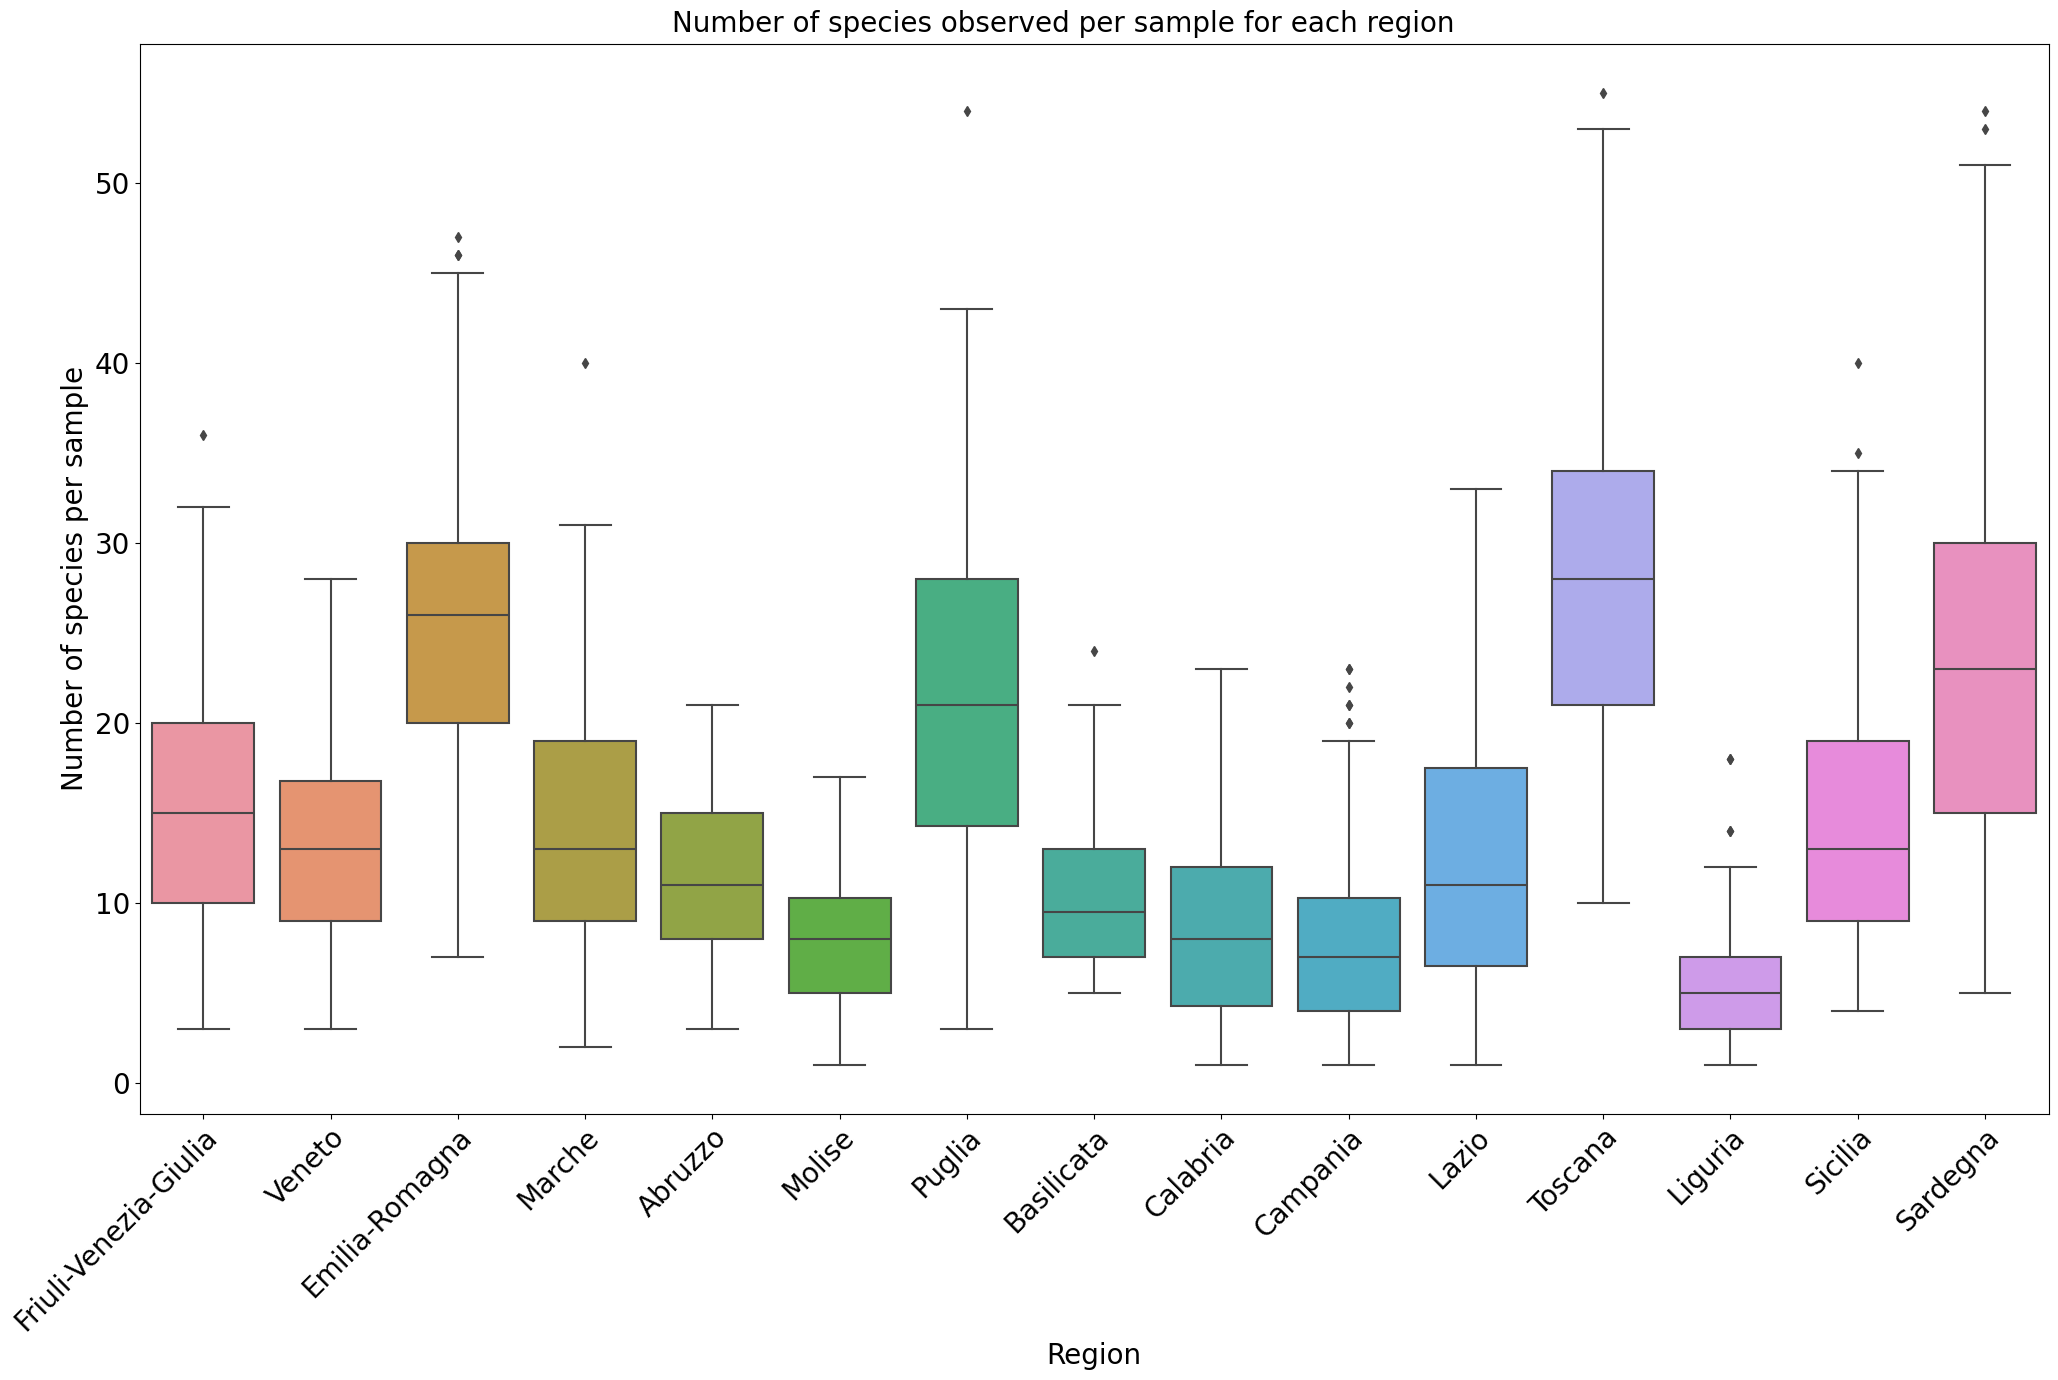

In [14]:
species = phyto_abund_simplified.query("Det_level == 'Species'")[["Region", "id", "Date", "Taxon"]]
species = species.groupby(["Region", "id", "Date"]).count().reset_index()
species["Region"] = pd.Categorical(species["Region"], ordered=True, categories=ordered_regions)
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.boxplot(species, x = "Region", y = "Taxon")
ax.set_ylabel("Number of species per sample", fontsize = 20)
ax.set_xlabel(xlabel = "Region", fontsize = 20)
plt.suptitle("Number of species observed per sample for each region", fontsize = 20)
plt.tight_layout()
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 20);
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 20);
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/N_species_per_sample_by_region.png",bbox_inches='tight')

## By class

In [58]:
abund_class = phyto_abund_simplified.groupby(["id", "Date", "Class"]).sum("Num_cell_l").reset_index()

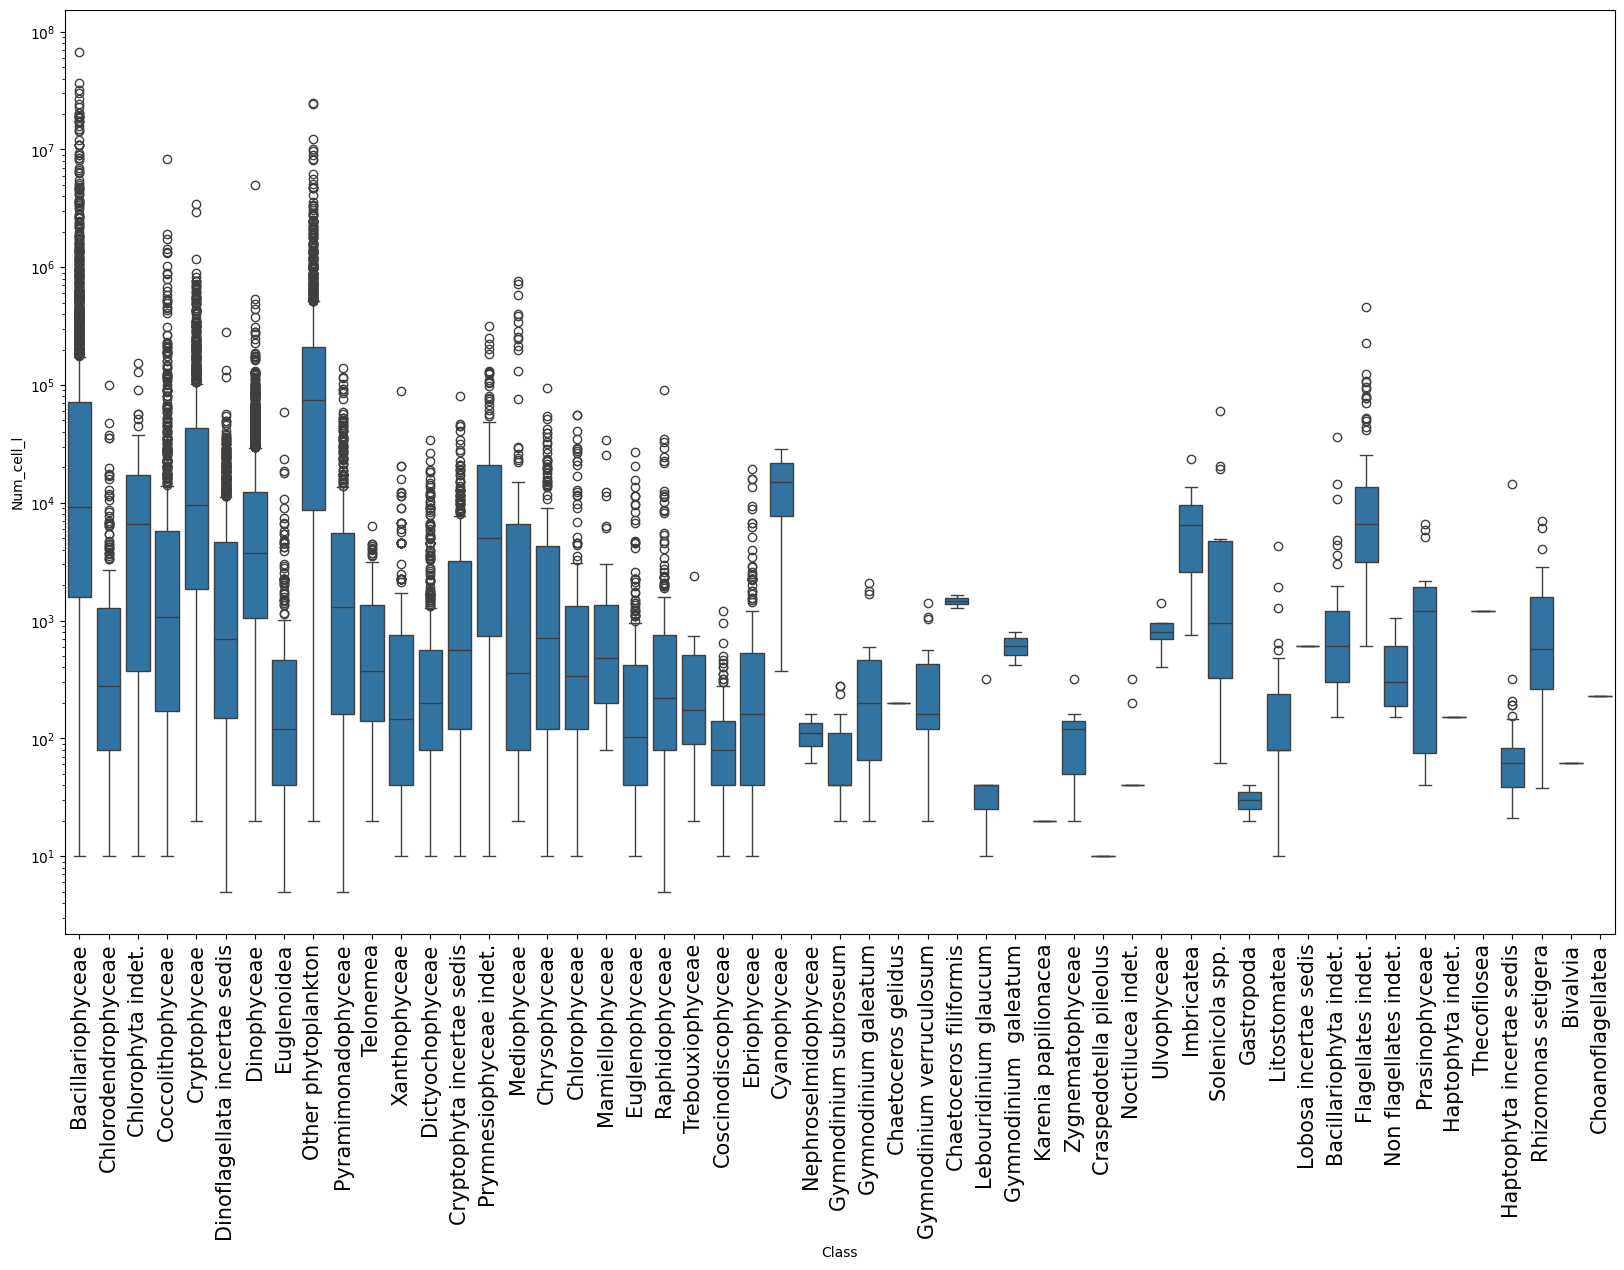

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.boxplot(abund_class, x = "Class", y = "Num_cell_l", ax = ax)
ax.set_yscale("log")
xlabels = ax.get_xticklabels()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xlabels, rotation = 90, size = 15);

In [64]:
taxonomic_tree.loc[taxonomic_tree["Phylum"] != "Bacillariophyta", "Class"].unique()

array(['Chlorophyceae', 'Coccolithophyceae', 'Raphidophyceae',
       'Cryptophyceae', 'Mamiellophyceae', 'Dinophyceae', 'Chrysophyceae',
       'Dictyochophyceae', 'Trebouxiophyceae', 'Ebriophyceae', nan,
       'Prasinophyceae', 'Prymnesiophyceae', 'Chlorodendrophyceae',
       'Pyramimonadophyceae', 'Cryptophyta incertae sedis',
       'Dinoflagellata incertae sedis', 'Euglenoidea', 'Telonemea',
       'Euglenophyceae', 'Litostomatea', 'Coscinodiscophyceae',
       'Mediophyceae', 'Xanthophyceae', 'Noctilucea', 'Ulvophyceae',
       'Synurophyceae', 'Imbricatea', 'Lobosa incertae sedis',
       'Thecofilosea', 'Cyanophyceae', 'Kinetoplastea',
       'Zygnematophyceae', 'Gastropoda', 'Nephroselmidophyceae',
       'Haptophyta incertae sedis', 'Bivalvia', 'Choanoflagellatea'],
      dtype=object)

# Composition Analysis 

## overall considerations

In [12]:
species_abund = phyto_abund_simplified.query("Det_level == 'Species'")

In [13]:
#unique species
len(species_abund["Taxon"].unique())

551

In [14]:
species_freq = species_abund.loc[:, "Taxon"].value_counts().reset_index()
for fraction in [0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.95, 1]: 
    print(species_freq["count"].quantile(fraction))

2.0
3.0
3.0
6.0
10.0
53.0
343.5
1676.0


In [15]:
freq_rare = 2
rare_species = species_freq.loc[species_freq["count"] <= freq_rare, "Taxon"].unique()

In [16]:
common_species = species_freq[species_freq['count'] > species_freq['count'].quantile(0.95)]
print(f"number of species above the 95 quantile = {len(common_species)}")
common_species

number of species above the 95 quantile = 28


,Taxon,count
0,Leptocylindrus danicus,1676
1,Proboscia alata,1293
2,Cylindrotheca closterium,1114
3,Chaetoceros curvisetus,1098
4,Dictyocha fibula,1052
5,Thalassionema nitzschioides,1041
6,Dactyliosolen fragilissimus,990
7,Cerataulina pelagica,821
8,Prorocentrum micans,793
9,Guinardia striata,793


In [62]:
#in che regioni le specie più frequenti non sono state viste TODO
where_common_not_found = {}
for species in common_species:
    regions_no_obs = set(ordered_regions).difference(set(species_abund["Region"]))
    if regions_no_obs: 
        where_common_not_found[species] = list(regions_no_obs)
np.unique(list(itertools.chain(*where_common_not_found.values())), return_counts=True)

In [17]:
species_median_abund = species_abund[["Taxon", "Num_cell_l"]].groupby("Taxon").median().sort_values("Num_cell_l", ascending=False)["Num_cell_l"]
abund_species = species_median_abund[species_median_abund > species_median_abund.quantile(0.95)]
abund_species

Taxon
Chaetoceros delicatulus                 117652.000000
Dinobryon coalescens                     22678.000000
Chaetoceros compressus                   14476.458948
Cyclotella meneghiniana                  13606.500000
Cyclotella caspia                        11339.000000
Cyclotella glomerata                     11339.000000
Oltmannsiella lineata                     9071.000000
Paulinella ovalis                         8637.000000
Skeletonema mediterranea                  7401.000000
Chaetoceros neglectus                     5027.000000
leucocryptos                              4635.000000
Ollicola vangoorii                        4319.000000
Bacteriastrum jadranum                    3269.605214
Chaetoceros throndsenii                   3019.000000
Skeletonema tropicum                      2800.000000
Pseudo-nitzschia delicatissima            2512.000000
Bacteriastrum parallelum                  2268.000000
Navicula directa                          2268.000000
Leptocylindrus convexu

In [18]:
species_abund.loc[(species_abund["Num_cell_l"] < 100) & (species_abund["Region"] == "Sardegna"), 
                  "Num_cell_l"].unique()

array([20., 50., 40., 10., 80., 30., 60., 90., 70., 25.,  5., 15., 55.,
       35., 45.])

<Axes: xlabel='Num_cell_l', ylabel='Count'>

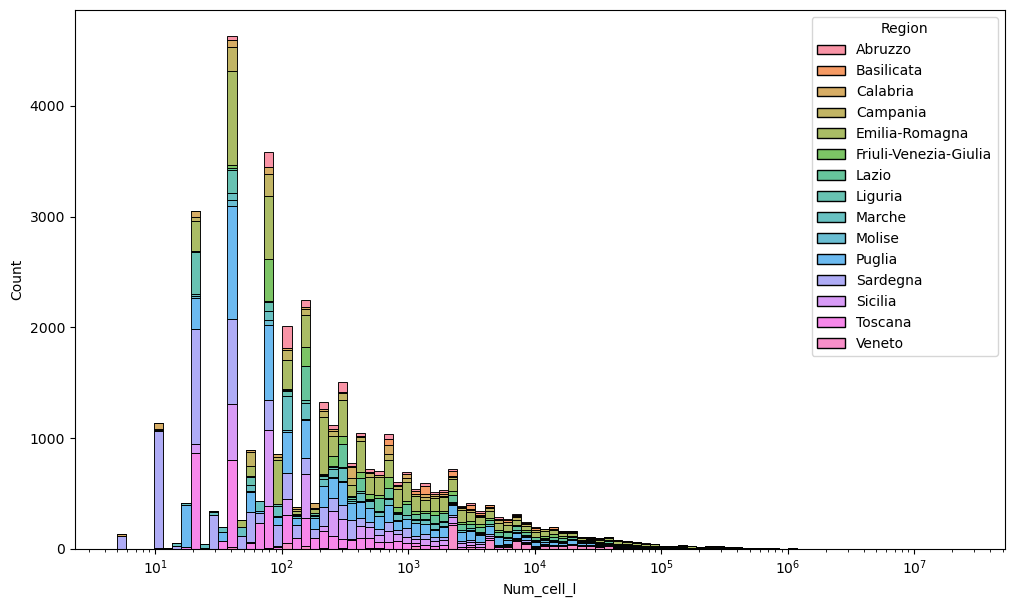

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_xscale("log")
sns.histplot(data = species_abund, 
             x = "Num_cell_l", 
             hue = "Region",
             multiple="stack",
             ax = ax
             )

In [28]:
df = phyto_abund_category.query("Det_level == 'Species'").loc[:, "Num_cell_l"]
for fraction in [0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.95, 1]: 
    print(df.quantile(fraction))

40.0
40.0
62.0
81.0
150.7964474
603.1857895
8545.000000000015
24119006.0


### frequency and rel. abund

In [72]:
relative_abund = phyto_abund_simplified[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"]).sum()
relative_abund = phyto_abund_simplified[["Region", "id", "Date", "Taxon", "Num_cell_l"]].set_index(["Region", "id", "Date", "Taxon"]).div(relative_abund)

In [109]:
n_samples = phyto_abund_simplified.drop_duplicates(["id", "Date"]).groupby(["Region", "id"]).count()[["Date"]]
n_samples = n_samples.loc[n_samples["Date"] > 9, :]

In [114]:
taxa_freq = phyto_abund_simplified[["Region", "id", "Date", "Taxon"]].groupby(["Region", "id", "Taxon"]).count()
taxa_freq = taxa_freq.divide(n_samples)

#### based on freq. 

In [138]:
threshold = 0.1
taxa_low_freq = taxa_freq.loc[taxa_freq["Date"] <= threshold, :]

In [143]:
relative_abund.reset_index(["Date"]).loc[taxa_low_freq.index, :].query("Num_cell_l > 0.1")

Date  Num_cell_l
Region  id          Taxon                                            
Abruzzo 1_ABR_GU04  Leptocylindrus minimus     2017-03-31    0.214815
        1_ABR_GU06  Paralia sulcata            2015-11-30    0.173333
                    Scrippsiella spp.          2015-07-31    0.232143
        1_ABR_VA13  Chaetoceros messanensis    2017-03-31    0.105511
                    Dinophysis caudata         2017-08-31    0.115385
...                                                   ...         ...
Toscana SMR_CPI_WA3 Chaetoceros wighamii       2016-05-31    0.189110
                    Phaeocystis spp.           2016-07-31    0.132912
Veneto  50720       Cyclotella meneghiniana    2016-07-31    0.153193
        60530       Asterionellopsis glacialis 2016-11-30    0.114502
        70720       Asterionellopsis glacialis 2016-11-30    0.282609

[196 rows x 2 columns]

## Richness & Evenness

### richness

<Axes: xlabel='Region', ylabel='Num_cell_l'>

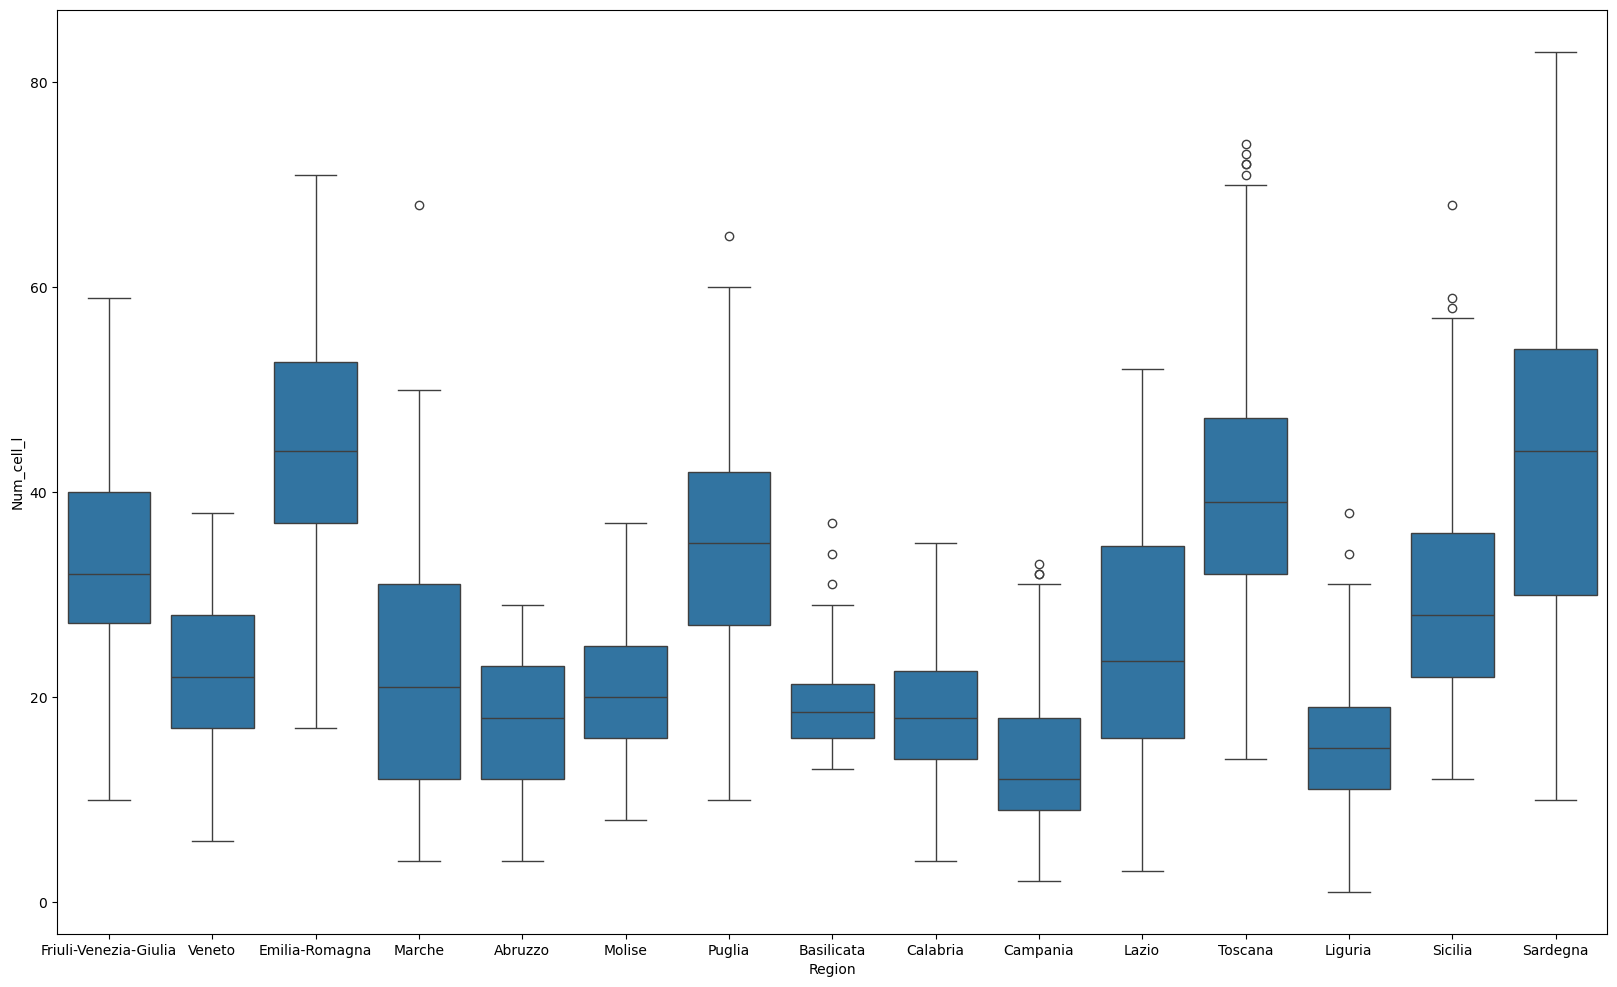

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.boxplot(phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"]).agg({"Num_cell_l" : "count"}).loc[ordered_regions, :], 
            y = "Num_cell_l", 
            x = "Region", 
            ax = ax)

In [52]:
description = "viollnplots of richness  divided by season, no rarefaction"
@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 

    for (region, df_region) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Region"):

        ## abund per coastal distance
        abund_by_coast_dist = df_region.groupby(["id", "Date"]).agg({"Num_cell_l" : "count", "Season" : "first"}).reset_index()
        
        ## create figure
        fig, ax  = plt.subplots(figsize=(10, 13))

        ## boxplot 
        sns.violinplot(data = abund_by_coast_dist, x = "Season", y = "Num_cell_l", hue = "Season", ax = ax)
        ax.set_xlabel("Season", size = 15)
        ax.set_ylabel("Taxa richness", size = 15)
        ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
        ax.set_title(region, size = 20)

        plt.savefig(f"{file_path}/{output_dir}/{region}_richness.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots", "Richness_season")

/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/3129409748.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.

In [55]:
description = "boxplots of richness  divided by coastal distance, no rarefaction"
@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 

    for (region, df_region) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Region"):

        ## abund per coastal distance
        abund_by_coast_dist = df_region.groupby(["id", "Date"]).agg({"Num_cell_l" : "count", "Coast_dist" : "first"}).reset_index()
        
        ## create figure
        fig, ax  = plt.subplots(figsize=(10, 13))

        ## boxplot 
        sns.boxplot(data = abund_by_coast_dist, x = "Coast_dist", y = "Num_cell_l", hue = "Coast_dist", ax = ax)
        ax.set_xlabel("Coastal distance", size = 15)
        ax.set_ylabel("Taxa richness", size = 15)
        ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
        ax.set_title(region, size = 20)

        plt.savefig(f"{file_path}/{output_dir}/{region}_richness.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots", "Richness_coast_dist")

/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation_mode = "anchor", rotation = 45, size = 15)
/tmp/ipykernel_20569/2533695383.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.

### evenness

<Axes: xlabel='Region', ylabel='Num_cell_l'>

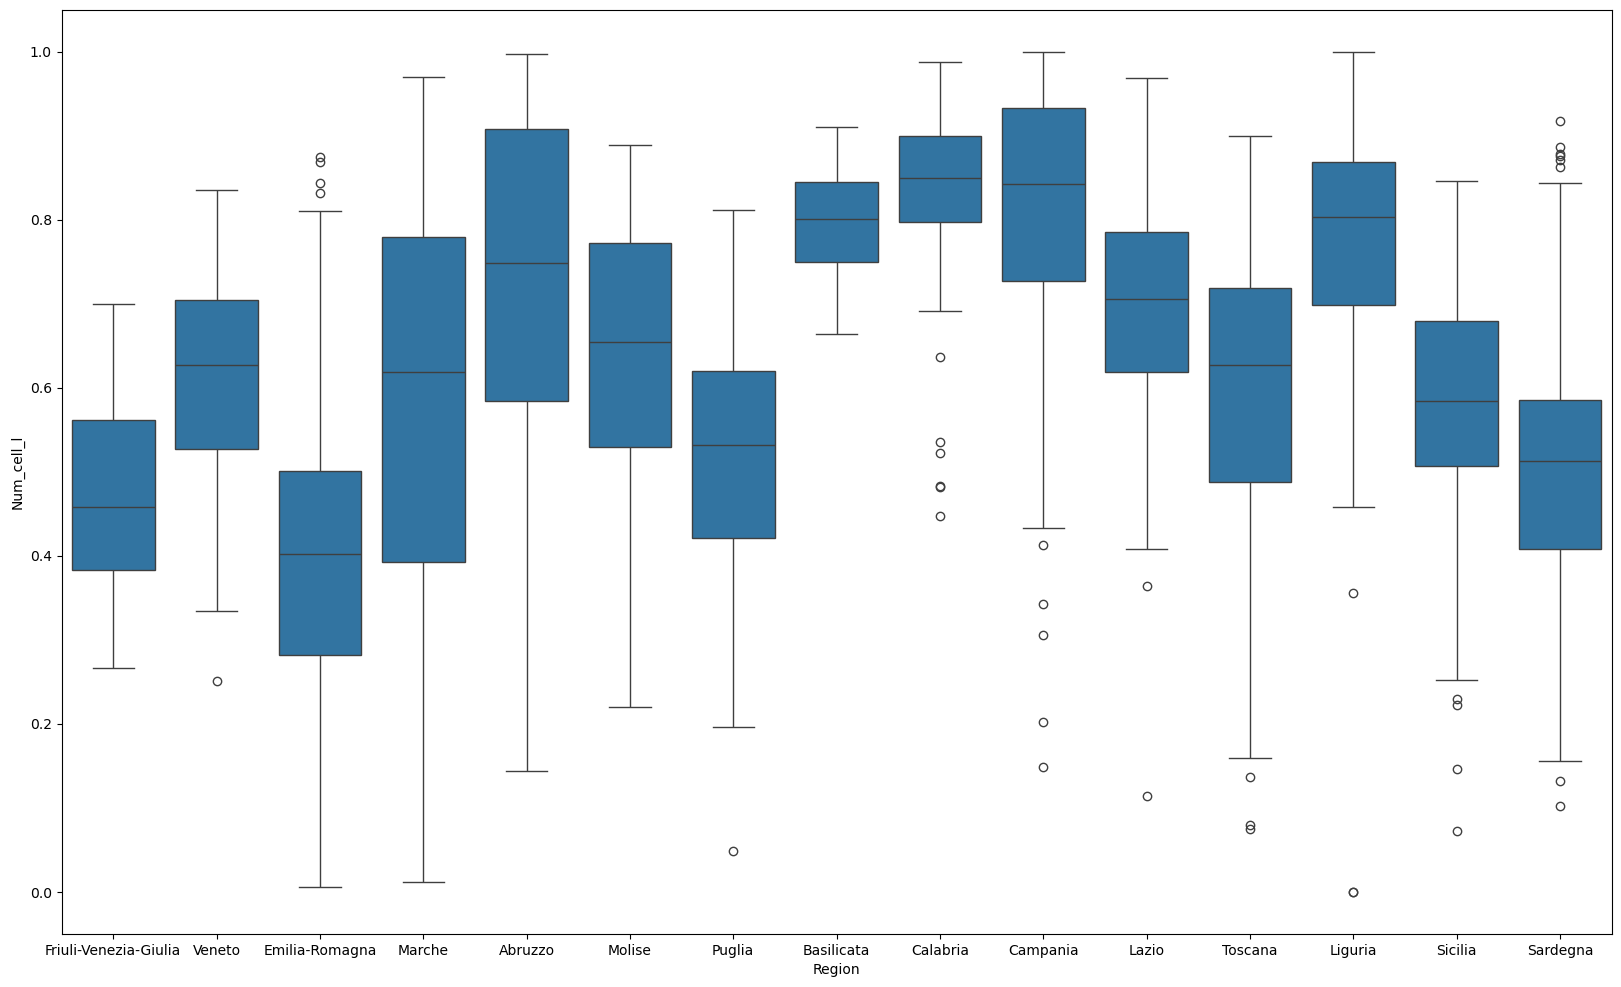

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.boxplot(phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"])[["Num_cell_l"]].agg(Pielou_evenness).loc[ordered_regions, :], 
            y = "Num_cell_l", 
            x = "Region", 
            ax = ax)

In [225]:
def chi_square_dist(data): 
    """distance computed betweeen rows"""
    tot = np.sqrt(np.sum(data))
    N_i,N_j = data.shape
    q = np.zeros((N_i,N_j))
    row_sum = np.sum(data, axis = 1)
    col_sum = np.sum(data, axis = 0)
    for i in range(N_i): 
        for j in range(N_j): 
            q[i,j] = data[i,j] / ( row_sum[i]* np.sqrt(col_sum[j]))
    return euclidean_distances(q)

In [227]:
chi_square_dist(np.array([[0,1,1], [1,0,0], [0,4,8]]))

array([[0.        , 1.03816077, 0.09296223],
       [1.03816077, 0.        , 1.03518353],
       [0.09296223, 1.03518353, 0.        ]])

## heatmap on frequency

is turnover present?

In [59]:
_PATH_ = _HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Freq_regions/"

if not os.path.exists(_PATH_):
        os.mkdir(_PATH_)

for region in ordered_regions: 
    fig, ax = plt.subplots(1,1, figsize=(20, 11))
    freq_species = phyto_abund_simplified.query("Region == @region")[["Season", "Taxon", "id"]].groupby(["Season", "Taxon"]).count()
    freq_samples = phyto_abund_simplified.query("Region == @region").drop_duplicates(["Date", "id"])[["Season", "id"]].groupby("Season").count()
    freq_species = freq_species.div(freq_samples)
    sns.heatmap(freq_species.reset_index().pivot(index="Season", columns="Taxon", values="id").fillna(0), ax = ax)
    plt.tight_layout()
    plt.savefig(_PATH_ + f"/freq_{region}.png")
    plt.close()


## heatmap on abund

In [73]:
_PATH_ = _HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_regions/"

if not os.path.exists(_PATH_):
        os.mkdir(_PATH_)
    
for region in ordered_regions: 
    fig, ax = plt.subplots(1,1, figsize=(20, 11))
    abund_species = phyto_abund_simplified.query("Region == @region")[["Season", "Taxon", "Num_cell_l"]].groupby(["Season", "Taxon"]).sum()
    abund_samples = phyto_abund_simplified.query("Region == @region")[["Season", "Num_cell_l"]].groupby("Season").sum()
    abund_species = abund_species.div(abund_samples)
    sns.heatmap(abund_species.reset_index().pivot(index="Season", columns="Taxon", values="Num_cell_l").fillna(0), ax = ax, norm = LogNorm(), cmap="jet")
    plt.tight_layout()
    plt.savefig(_PATH_ + f"/abund_{region}.png")
    plt.close()


## IndVal per regione

In [15]:
ind_val_df_regions = {}
for region in ordered_regions: 
    df = phyto_abund_simplified[["Region", "id", "Date", "Taxon", "Num_cell_l", "Season"]].query("Region == @region")
        #df.loc[:, "Month"] = pd.to_datetime(df.loc[:, "Date"]).dt.month.to_numpy()
    ind_val_df_regions[region]= modify_dataset.IndVal(df, cluster_on="Season")

In [31]:
df = ind_val_df_regions["Abruzzo"].values.T
df["max_indval"] = df.max(axis = 1)
df.sort_values("max_indval", ascending=False).query("max_indval >= 0.25")

Season,Winter,Spring,Summer,Autumn,max_indval
Taxon,,,,,
Skeletonema costatum,0.583333,0.000000,0.000000,0.000000,0.583333
Proboscia alata,0.014118,0.000000,0.505601,0.148502,0.505601
Pseudo-nitzschia spp.,0.234212,0.000561,0.125599,0.494237,0.494237
Micromonas spp.,0.000000,0.012718,0.200775,0.490864,0.490864
Thalassionema nitzschioides,0.189775,0.008508,0.483333,0.007390,0.483333
Leptocylindrus danicus,0.464914,0.000000,0.026754,0.035106,0.464914
Lioloma pacificum,0.000159,0.000000,0.005024,0.463323,0.463323
Karenia mikimotoi,0.000000,0.385802,0.002469,0.000000,0.385802
Scrippsiella trochoidea,0.030574,0.118897,0.385303,0.089356,0.385303


### with threshold

how to choose threshold?

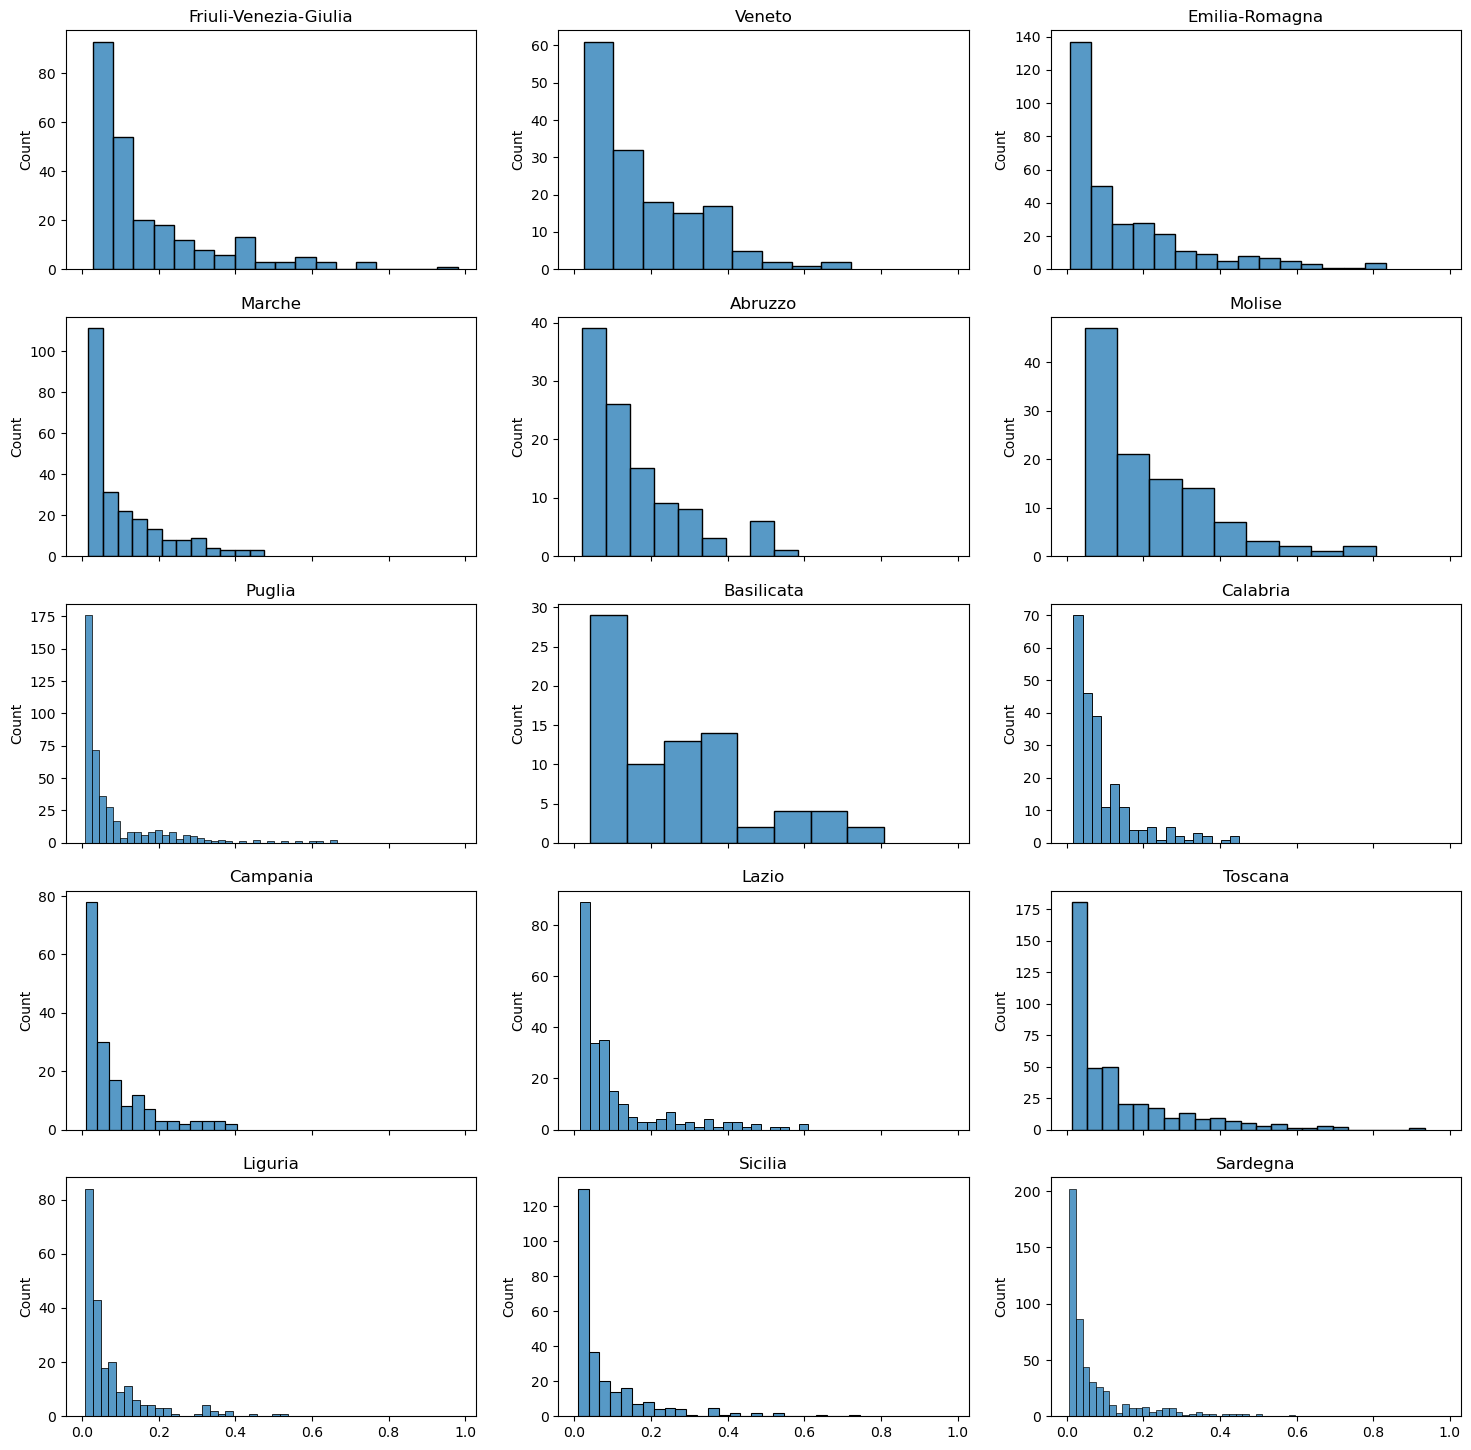

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18), sharex = True)
axs = axs.flat
for ax, (reg_name, indval_reg) in zip(axs, ind_val_df_regions.items()): 
    sns.histplot(indval_reg.max_values, ax = ax)
    ax.set_title(reg_name)

In [10]:
selected_taxa = pd.DataFrame(
    {
        "Region" : [], 
        "IndVal_value" : [],
        "percent_taxa" : []
    }
)
quantiles = np.arange(0.2,1.05,step = 0.05)
for (region, indval_reg) in ind_val_df_regions.items(): 
    df = pd.DataFrame({
        "Region" : [], 
        "IndVal_value" : [],
        "percent_taxa" : []
    }
    )
    df["IndVal_value"] = quantiles
    df["percent_taxa"] = [indval_reg.select_species_above_threshold(limit).size / indval_reg.max_values.size for limit in quantiles]
    df["Region"] = region
    selected_taxa = pd.concat([selected_taxa, df], axis = 0)
selected_taxa.reset_index(drop = True, inplace=True)

(0.15, 0.5)

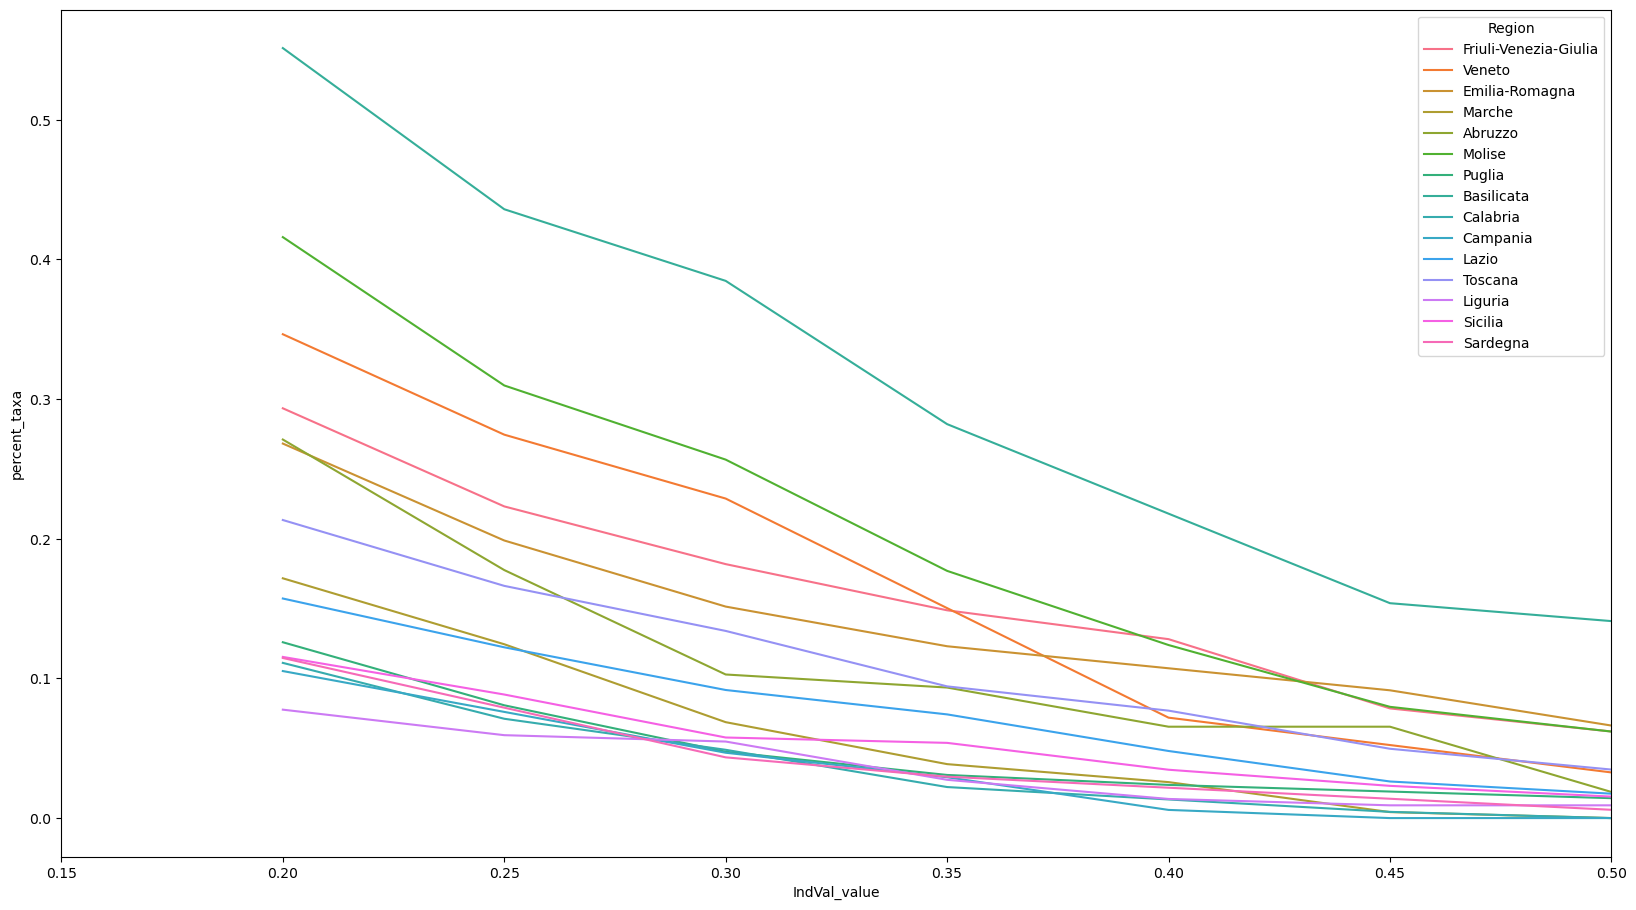

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20, 11))
sns.lineplot(selected_taxa, x = "IndVal_value", y = "percent_taxa", hue = "Region", ax = ax)
ax.set_xlim([0.15, 0.5])

In [12]:
selected_taxa.pivot_table(values = "percent_taxa", index = "Region", columns = "IndVal_value")

IndVal_value,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
Region,,,,,,,,,,,,,,,,,
Abruzzo,0.271028,0.177570,0.102804,0.093458,0.065421,0.065421,0.018692,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Basilicata,0.551282,0.435897,0.384615,0.282051,0.217949,0.153846,0.141026,0.089744,0.076923,0.038462,0.025641,0.025641,0.012821,0.000000,0.000000,0.000000,0.0
Calabria,0.111111,0.071111,0.048889,0.022222,0.013333,0.004444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Campania,0.105263,0.076023,0.046784,0.029240,0.005848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Emilia-Romagna,0.268139,0.198738,0.151420,0.123028,0.107256,0.091483,0.066246,0.053628,0.028391,0.018927,0.015773,0.015773,0.009464,0.000000,0.000000,0.000000,0.0
Friuli-Venezia-Giulia,0.293388,0.223140,0.181818,0.148760,0.128099,0.078512,0.061983,0.049587,0.033058,0.016529,0.016529,0.008264,0.004132,0.004132,0.004132,0.004132,0.0
Lazio,0.157205,0.122271,0.091703,0.074236,0.048035,0.026201,0.017467,0.008734,0.004367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Liguria,0.077626,0.059361,0.054795,0.027397,0.013699,0.009132,0.009132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Marche,0.171674,0.124464,0.068670,0.038627,0.025751,0.004292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [13]:
selected_taxa = pd.DataFrame(
    {
        "Region" : [], 
        "quantiles" : [],
        "percent_taxa" : []
    }
)
quantiles = np.arange(0.2,1.05,step = 0.05)
for (region, indval_reg) in ind_val_df_regions.items(): 
    df = pd.DataFrame({
        "Region" : [], 
        "quantiles" : [],
        "percent_taxa" : []
    }
    )
    df["quantiles"] = quantiles
    df["percent_taxa"] = [indval_reg.select_species_above_threshold(indval_reg.max_values.quantile(limit)).size / indval_reg.max_values.size for limit in quantiles]
    df["Region"] = region
    selected_taxa = pd.concat([selected_taxa, df], axis = 0)
selected_taxa.reset_index(drop = True, inplace=True)

<Axes: xlabel='quantiles', ylabel='percent_taxa'>

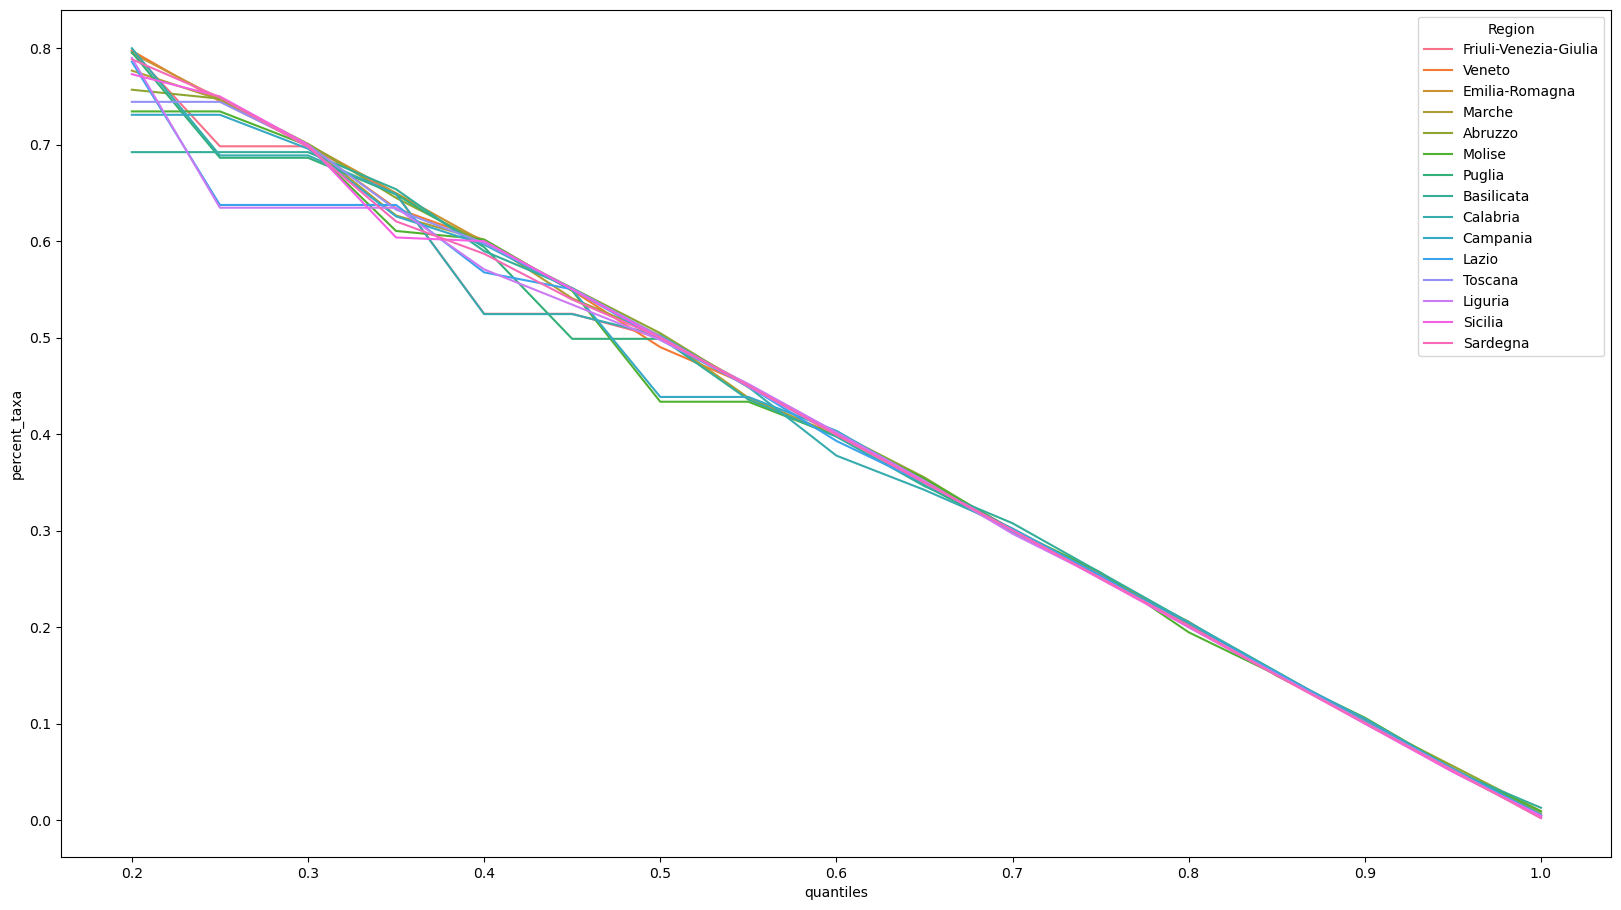

In [124]:
fig, ax = plt.subplots(1,1, figsize=(20, 11))
sns.lineplot(selected_taxa, x = "quantiles", y = "percent_taxa", hue = "Region", ax = ax)

In [15]:
selected_taxa.pivot_table(values = "percent_taxa", index = "Region", columns = "quantiles")

quantiles,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
Region,,,,,,,,,,,,,,,,,
Abruzzo,0.757009,0.747664,0.700935,0.644860,0.598131,0.551402,0.504673,0.448598,0.401869,0.355140,0.299065,0.252336,0.205607,0.149533,0.102804,0.056075,0.009346
Basilicata,0.692308,0.692308,0.692308,0.653846,0.589744,0.551282,0.500000,0.435897,0.397436,0.346154,0.307692,0.256410,0.205128,0.153846,0.102564,0.051282,0.012821
Calabria,0.800000,0.688889,0.688889,0.648889,0.524444,0.524444,0.502222,0.448889,0.377778,0.342222,0.302222,0.253333,0.200000,0.151111,0.102222,0.053333,0.004444
Campania,0.730994,0.730994,0.695906,0.625731,0.596491,0.549708,0.438596,0.438596,0.403509,0.350877,0.298246,0.251462,0.204678,0.152047,0.105263,0.052632,0.005848
Emilia-Romagna,0.794953,0.747634,0.700315,0.649842,0.599369,0.548896,0.501577,0.451104,0.400631,0.350158,0.299685,0.252366,0.201893,0.151420,0.100946,0.050473,0.003155
Friuli-Venezia-Giulia,0.797521,0.698347,0.698347,0.648760,0.524793,0.524793,0.500000,0.450413,0.400826,0.351240,0.301653,0.252066,0.202479,0.152893,0.103306,0.053719,0.004132
Lazio,0.786026,0.637555,0.637555,0.637555,0.567686,0.550218,0.497817,0.449782,0.393013,0.349345,0.301310,0.253275,0.200873,0.152838,0.100437,0.052402,0.004367
Liguria,0.789954,0.634703,0.634703,0.634703,0.570776,0.534247,0.497717,0.452055,0.401826,0.351598,0.296804,0.251142,0.200913,0.150685,0.100457,0.050228,0.004566
Marche,0.776824,0.746781,0.699571,0.626609,0.600858,0.540773,0.502146,0.437768,0.399142,0.351931,0.300429,0.253219,0.201717,0.150215,0.103004,0.051502,0.004292


In [11]:
important_species = pd.DataFrame(
    {
    }
)
for region in ordered_regions:
    threshold_indval = ind_val_df_regions[region].max_values.quantile(0.8)    
    df = ind_val_df_regions[region].values.loc[:, ind_val_df_regions[region].select_species_above_threshold(threshold_indval)].stack().reset_index()
    df["Region"] = region
    important_species = pd.concat([important_species, df], axis = 0)
important_species.rename(columns={0 : "IndVal"}, inplace=True)

In [136]:
if not os.path.exists(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Indval_regions"):
        os.mkdir(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Indval_regions")


for region in ordered_regions:
    fig, ax = plt.subplots(1,1, figsize=(20, 11))
    df = important_species.query("Region == @region")
    idx = df.groupby("Taxon")["IndVal"].idxmax()
    taxa = df.loc[idx].sort_values(["Season", "IndVal"], ascending=[True, False])["Taxon"]
    sns.heatmap(ind_val_df_regions[region].values.reindex(columns = taxa), 
            ax = ax, 
                    )
    plt.tight_layout()
    plt.savefig(_HOME_ + f"/PHD/ISPRA_20152017_Analysis/Plots/Indval_regions/indval_{region}.png")
    plt.close()

In [15]:
phyto_abund_simplified

,Region,id,Longitude,Latitude,Date,Sample_depth,Group,Genus,Taxon,Num_cell_l,file_name,Closest_coast,Det_level,Season_year,Season,Coast_dist
0,Abruzzo,1_ABR_GU04,14.0418,42.7609,2015-07-23,0.5,Altro fitoplancton,Dunaliella,Dunaliella spp.,480.0,Modulo_1_20160629142447_ARPA_Emilia-Romagna_Ab...,5.556,Genus,Summer-2015,Summer,near
1,Abruzzo,1_ABR_GU04,14.0418,42.7609,2015-07-23,0.5,Altro fitoplancton,Emiliania,Emiliania huxleyi,80.0,Modulo_1_20160629142447_ARPA_Emilia-Romagna_Ab...,5.556,Species,Summer-2015,Summer,near
2,Abruzzo,1_ABR_GU04,14.0418,42.7609,2015-07-23,0.5,Altro fitoplancton,Fibrocapsa,Fibrocapsa japonica,40.0,Modulo_1_20160629142447_ARPA_Emilia-Romagna_Ab...,5.556,Species,Summer-2015,Summer,near
3,Abruzzo,1_ABR_GU04,14.0418,42.7609,2015-07-23,0.5,Altro fitoplancton,Hillea,Hillea fusiformis,200.0,Modulo_1_20160629142447_ARPA_Emilia-Romagna_Ab...,5.556,Species,Summer-2015,Summer,near
4,Abruzzo,1_ABR_GU04,14.0418,42.7609,2015-07-23,0.5,Altro fitoplancton,Micromonas,Micromonas spp.,160.0,Modulo_1_20160629142447_ARPA_Emilia-Romagna_Ab...,5.556,Genus,Summer-2015,Summer,near
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64578,Veneto,70720,12.6064,45.1676,2017-11-28,0.5,Diatomee,Pseudonitzschia,Pseudonitzschia spp. del nitzschia delicatissi...,7937.0,Modulo_1_20180604083502_ARPA_Emilia-Romagna_Ve...,12.000,Genus,Autumn-2017,Autumn,middle
64579,Veneto,70720,12.6064,45.1676,2017-11-28,0.5,Diatomee,Thalassionema,Thalassionema nitzschioides,11339.0,Modulo_1_20180604083502_ARPA_Emilia-Romagna_Ve...,12.000,Species,Autumn-2017,Autumn,middle
64580,Veneto,70720,12.6064,45.1676,2017-11-28,0.5,Diatomee,Thalassiosira,Thalassiosira rotula,6803.0,Modulo_1_20180604083502_ARPA_Emilia-Romagna_Ve...,12.000,Species,Autumn-2017,Autumn,middle
64581,Veneto,70720,12.6064,45.1676,2017-11-28,0.5,Dinoflagellati,Prorocentrum,Prorocentrum compressum,1134.0,Modulo_1_20180604083502_ARPA_Emilia-Romagna_Ve...,12.000,Species,Autumn-2017,Autumn,middle


In [14]:
df

,Season,Taxon,IndVal,Region
0,Autumn,Alexandrium spp.,0.014750,Friuli-Venezia-Giulia
1,Autumn,Bacteriastrum jadranum,0.000000,Friuli-Venezia-Giulia
2,Autumn,Cerataulina pelagica,0.013182,Friuli-Venezia-Giulia
3,Autumn,Ceratium furca,0.000000,Friuli-Venezia-Giulia
4,Autumn,Ceratium fusus,0.011905,Friuli-Venezia-Giulia
...,...,...,...,...
191,Winter,Scrippsiella spp.,0.014437,Friuli-Venezia-Giulia
192,Winter,Thalassionema nitzschioides,0.002251,Friuli-Venezia-Giulia
193,Winter,Thalassionema spp.,0.009458,Friuli-Venezia-Giulia
194,Winter,Thalassiosira spp.,0.330679,Friuli-Venezia-Giulia


<Axes: xlabel='Taxon', ylabel='Season'>

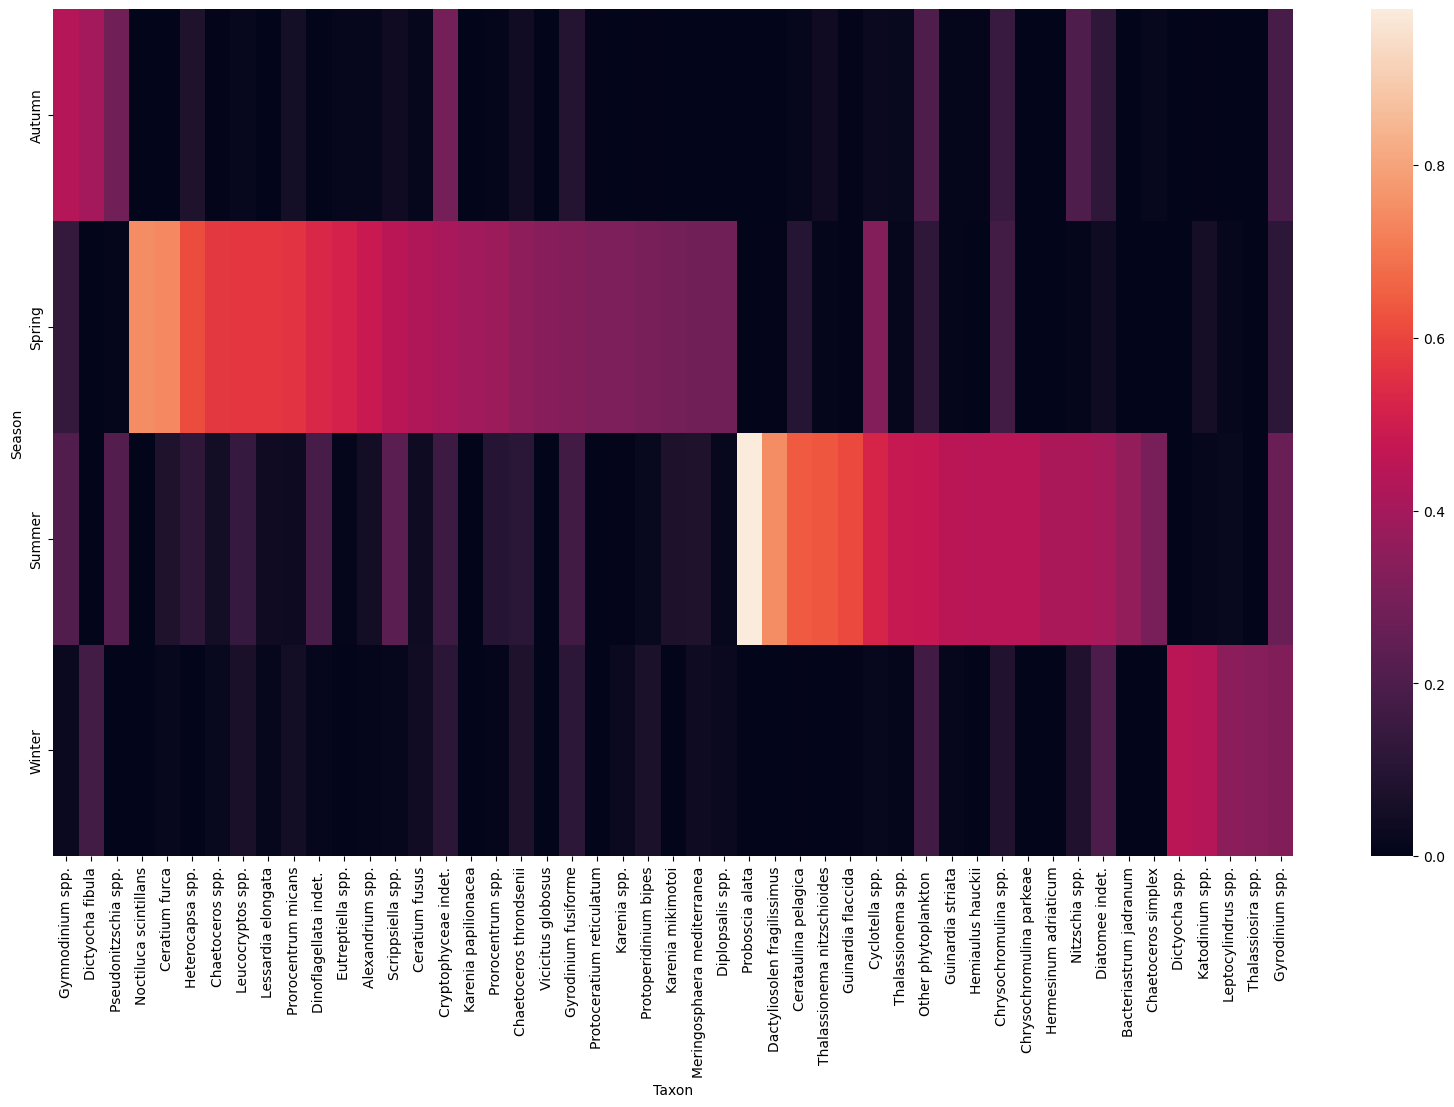

In [13]:
fig, ax = plt.subplots(1,1, figsize=(20, 11))
region = ordered_regions[0]
df = important_species.query("Region == @region")
idx = df.groupby("Taxon")["IndVal"].idxmax()
taxa = df.loc[idx].sort_values(["Season", "IndVal"], ascending=[True, False])["Taxon"]
sns.heatmap(ind_val_df_regions[region].values.reindex(columns = taxa), 
        ax = ax, 
                )

### without threshold

In [10]:
important_species = pd.DataFrame(
    {
    }
)
for region in ordered_regions:
    threshold_indval = ind_val_df_regions[region].max_values.quantile(0.8)    
    df = ind_val_df_regions[region].values.stack().reset_index()
    df["Region"] = region
    important_species = pd.concat([important_species, df], axis = 0)
important_species.rename(columns={0 : "IndVal"}, inplace=True)

In [12]:
_PATH_ = _HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Indval_regions/all_species"

if not os.path.exists(_PATH_):
        os.mkdir(_PATH_)

for region in ordered_regions:
    fig, ax = plt.subplots(1,1, figsize=(20, 11))
    df = important_species.query("Region == @region")
    idx = df.groupby("Taxon")["IndVal"].idxmax()
    taxa = df.loc[idx].sort_values(["Season", "IndVal"], ascending=[True, False])["Taxon"]
    sns.heatmap(ind_val_df_regions[region].values.reindex(columns = taxa), 
            ax = ax, 
                    )
    plt.tight_layout()
    plt.savefig(_PATH_ + f"/indval_{region}.png")
    plt.close()